# Parallel `ContactTrajectory` with Dask

Each frame that makes up a `ContactTrajectory` can have its contact map calculated in parallel. This shows how to use [dask.distributed](https://distributed.readthedocs.io/) to do this (in a similat way as we showed for `ContactFrequency` in `dask_contact_frequency.ipynb`).

We'll look at this using a trajectory of a specific inhibitor during its binding process to GSK3B. This system is also studied in the notebook on contact concurrences (with very similar initial discussion).

In [1]:
%matplotlib inline
# dask and distributed are extra installs
import contact_map
from dask.distributed import Client, LocalCluster
import matplotlib.pyplot as plt

import mdtraj as md
traj = md.load("data/gsk3b_example.h5")

topology = traj.topology
yyg = topology.select('resname YYG and element != "H"')
protein = topology.select('protein and element != "H"')

First we need to connect a client to a dask network.

Note that there are several ways to set up the dask computer network and then connect a client to it. See https://distributed.readthedocs.io/en/latest/setup.html. The approach used here creates a `LocalCluster`. Large scale simulations would need other approaches. For clusters, you can manually run a `dask-scheduler` and multiple `dask-worker` commands. By using the same `sched.json`, it is easy to have different workers in different jobs on the cluster's scheduling system.

In [2]:
c = LocalCluster()
client = Client(c)

In [3]:
# if you started on a cluster and the scheduler file is called sched.json
#client = Client(scheduler_file="./sched.json")

In [4]:
client

Client Scheduler: tcp://127.0.0.1:42507 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 12 Memory: 16.39 GB


In [5]:
%%time
freq = contact_map.DaskContactTrajectory(
    client=client,
    query=yyg,
    haystack=protein,
    filename="data/gsk3b_example.h5",
)
# top must be given as keyword (passed along to mdtraj.load)

CPU times: user 383 ms, sys: 34.4 ms, total: 418 ms
Wall time: 2.76 s


Note that on a single machine (shared memory) this may not improve performance. That is because the single-frame aspect of this calculation is already parallelized with OpenMP, and will therefore use all cores on the machine.

Next we check that we're still getting the same results:

In [6]:
# did it add up to give us the right number of frames?
len(freq)

100

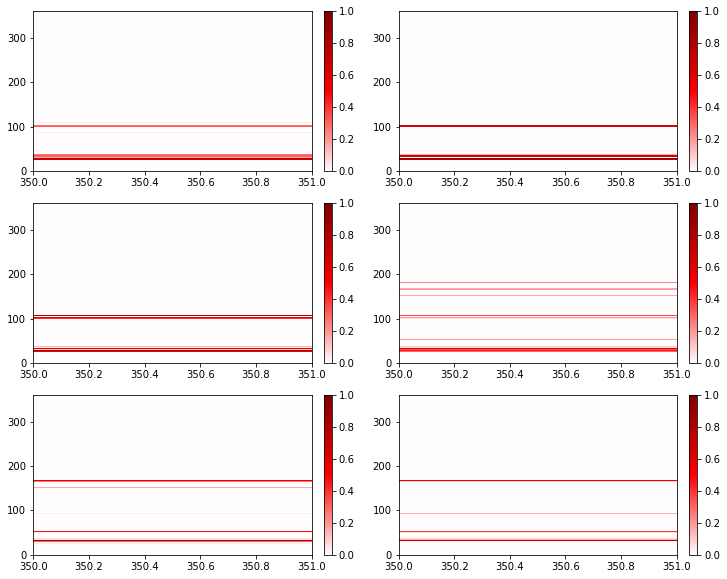

In [7]:
# do we get a familiar-looking residue map for rolling averages?
rolling_frequencies = freq.rolling_frequency(window_size=30, step=14)
rolling_frequencies

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
for ax, freq in zip(axs.flatten(), rolling_frequencies):
    freq.residue_contacts.plot_axes(ax=ax)
    ax.set_xlim(*freq.query_residue_range);

In [8]:
# Shutdown the cluster and client
client.shutdown()
client.close() # This line is needed to prevent a timeout error after 10 seconds